In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud #installing wordcloud library

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moyka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moyka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath(r'C:\Users\moyka\OneDrive\Documents\GitHub\week0_starter_network_analysis')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [6]:
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    # specify path to get json files
    combined = []
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            file_content = json.load(slack_data)
            combined.append(file_content)

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and len(row['blocks'][0]['elements'][0]['elements']) != 0 :
                     msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
    dfall = dfall.reset_index(drop=True)
    
    return dfall


def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))
                
    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [7]:
df = slack_parser(r'C:/Users/moyka/OneDrive/Documents/GitHub/allweeks89/')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_type           189 non-null    object
 1   msg_content        189 non-null    object
 2   sender_name        189 non-null    object
 3   msg_sent_time      189 non-null    object
 4   msg_dist_type      189 non-null    object
 5   time_thread_start  189 non-null    object
 6   reply_count        189 non-null    int64 
 7   reply_users_count  189 non-null    int64 
 8   reply_users        189 non-null    object
 9   tm_thread_end      189 non-null    object
 10  channel            189 non-null    object
dtypes: int64(2), object(9)
memory usage: 16.4+ KB


In [8]:
PSR = parse_slack_reaction(r'C:/Users/moyka/OneDrive/Documents/GitHub/allweeks89/', 'channel')
PSR[:5]

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
0,raised_hands,10,"U03UL5LSTG9,U03V785NLSU,U03UUR571A5,U03V61VGQG...",Good morning everyone :blush: welcome to week ...,U03TEPYRM2P,channel
1,clap,1,U03UUMR26Q1,Good morning everyone :blush: welcome to week ...,U03TEPYRM2P,channel
2,raised_hands::skin-tone-3,1,U03U9EJR362,Good morning everyone :blush: welcome to week ...,U03TEPYRM2P,channel
3,flushed,6,"U03U1FNPEUX,U03UJKJGRAQ,U03U1HAG9TR,U03UFV7HFN...","hi, i just want to confirm that the submission...",U03UD5B7C3X,channel
4,eyes,2,"U03UG1Z21JP,U03UJKJGRAQ","hi, i just want to confirm that the submission...",U03UD5B7C3X,channel


In [9]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [10]:
converted_time = convert_2_timestamp('msg_sent_time', df)
converted_time[:5]

['2022-10-10 10:08:27',
 '2022-10-10 10:08:54',
 '2022-10-10 10:09:20',
 '2022-10-10 10:33:34',
 '2022-10-10 10:48:47']

In [11]:
get_tagged_use = get_tagged_users(df)
get_tagged_use[:5]

0    []
1    []
2    []
3    []
4    []
Name: msg_content, dtype: object

In [12]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [13]:
pfill = slack_parser(r'C:/Users/moyka/OneDrive/Documents/GitHub/allweeks89/')
pfill.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_type           189 non-null    object
 1   msg_content        189 non-null    object
 2   sender_name        189 non-null    object
 3   msg_sent_time      189 non-null    object
 4   msg_dist_type      189 non-null    object
 5   time_thread_start  189 non-null    object
 6   reply_count        189 non-null    int64 
 7   reply_users_count  189 non-null    int64 
 8   reply_users        189 non-null    object
 9   tm_thread_end      189 non-null    object
 10  channel            189 non-null    object
dtypes: int64(2), object(9)
memory usage: 16.4+ KB


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [14]:
# which user has the highest number of reply counts?
#draw_avg_reply_users_count(pfill, channel='YourChannelName')
user_with_highest_replies = pfill.groupby('sender_name')['reply_count'].sum().idxmax()
print(f"The user with the highest number of reply counts is: {user_with_highest_replies}")

The user with the highest number of reply counts is: Katie Dickerson


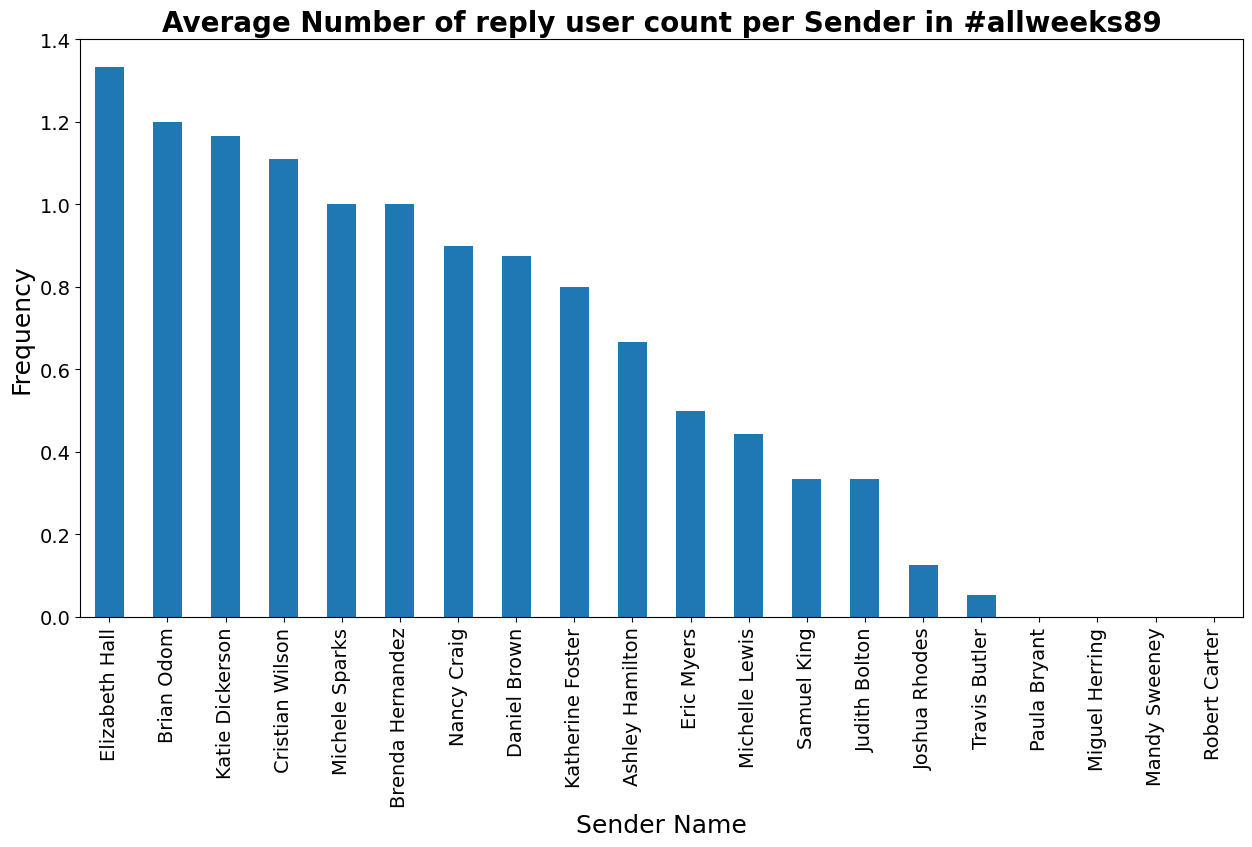

In [15]:
# Visualize reply counts per user per channel
draw_avg_reply_users_count(pfill,'allweeks89')

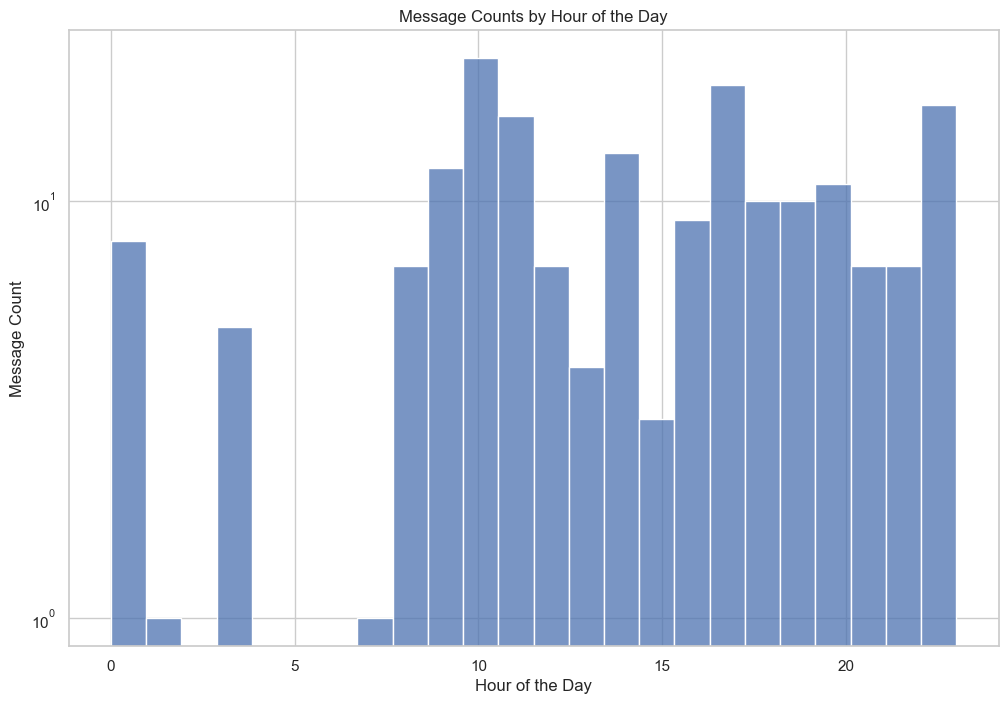

In [16]:
# what is the time range of the day that most messages are sent?
pfill['msg_sent_timestamp'] = utils.convert_2_timestamp('msg_sent_time', pfill)
pfill['hour'] = pd.to_datetime(pfill['msg_sent_timestamp']).dt.hour

# Plot the histogram
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.histplot(pfill['hour'], bins=24, kde=False)
plt.yscale('log')
plt.title('Message Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Message Count')

plt.show()

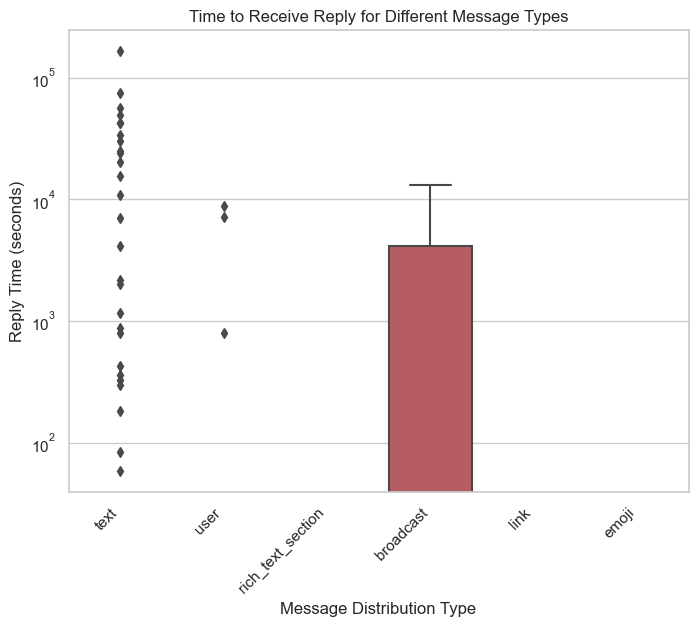

In [17]:
# what kind of messages are replied faster than others?
# Convert msg_sent_time and tm_thread_end to timestamps
pfill['msg_sent_timestamp'] = utils.convert_2_timestamp('msg_sent_time', pfill)
pfill['tm_thread_end_timestamp'] = utils.convert_2_timestamp('tm_thread_end', pfill)

# Calculate the time it takes to receive a reply
pfill['reply_time'] = (pd.to_datetime(pfill['tm_thread_end_timestamp']) - pd.to_datetime(pfill['msg_sent_timestamp'])).dt.total_seconds()

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.boxplot(x='msg_dist_type', y='reply_time', data=pfill)
plt.yscale('log')
plt.title('Time to Receive Reply for Different Message Types')
plt.xlabel('Message Distribution Type')
plt.ylabel('Reply Time (seconds)')
plt.xticks(rotation=45, ha='right')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


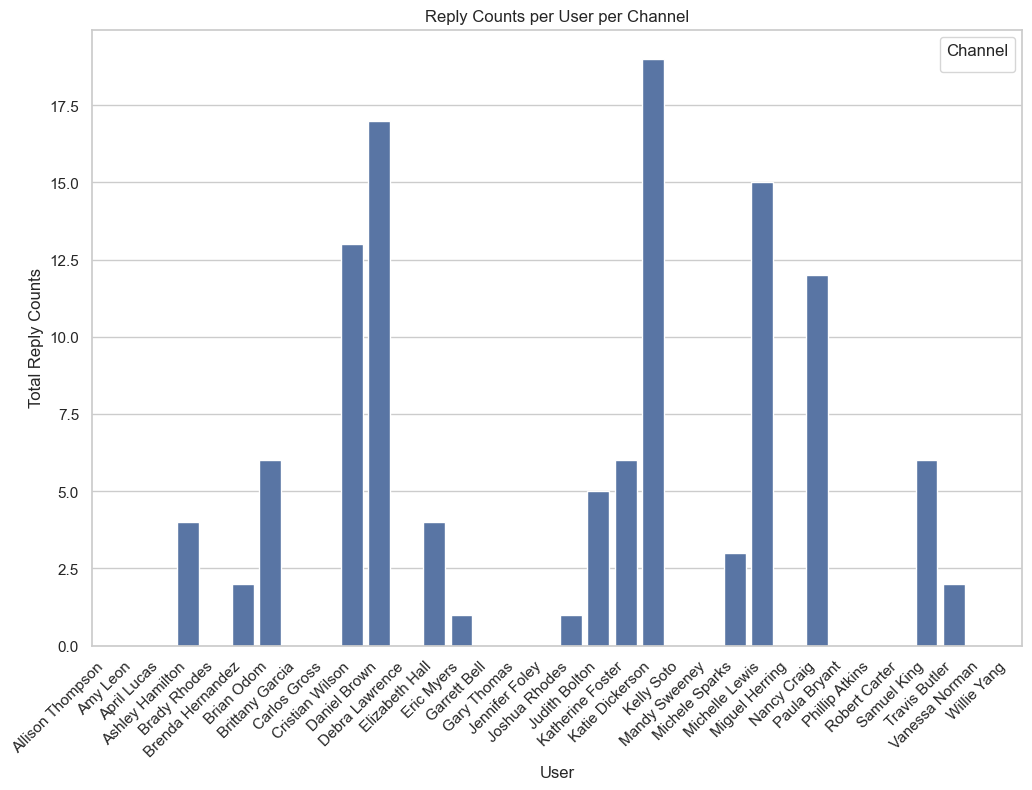

In [22]:
# Relationship between # of messages and # of reactions
grouped_data = pfill.groupby(['sender_name', 'channel'])['reply_count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='sender_name', y='reply_count', hue='channel', data=grouped_data)
plt.title('Reply Counts per User per Channel')
plt.xlabel('User')
plt.ylabel('Total Reply Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Channel', loc='upper right')
plt.show()

category
Other       179
Question      8
Answer        2
Name: count, dtype: int64


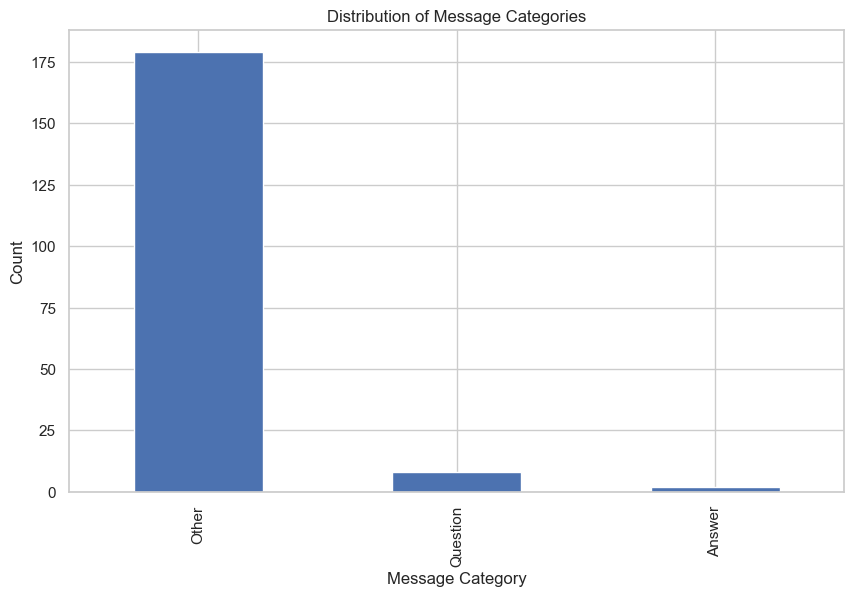

In [19]:
# Classify messages into different categories such as questions, answers, comments, etc.
# Get tagged users in the messages
pfill['tagged_users'] = get_tagged_users(pfill)

# Create new columns for message categories
pfill['category'] = 'Other'  # Default category

# Identify and classify messages based on certain keywords or patterns
pfill.loc[pfill['msg_content'].str.contains('(?:^|\W)\\?+'), 'category'] = 'Question'
pfill.loc[pfill['msg_content'].str.contains('(?:^|\W)answer(?:$|\W)', case=False), 'category'] = 'Answer'
pfill.loc[pfill['msg_content'].str.contains('(?:^|\W)comment(?:$|\W)', case=False), 'category'] = 'Comment'

# Display the distribution of message categories
category_counts = pfill['category'].value_counts()
print(category_counts)

# Plot the distribution
category_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Message Categories')
plt.xlabel('Message Category')
plt.ylabel('Count')
plt.show()

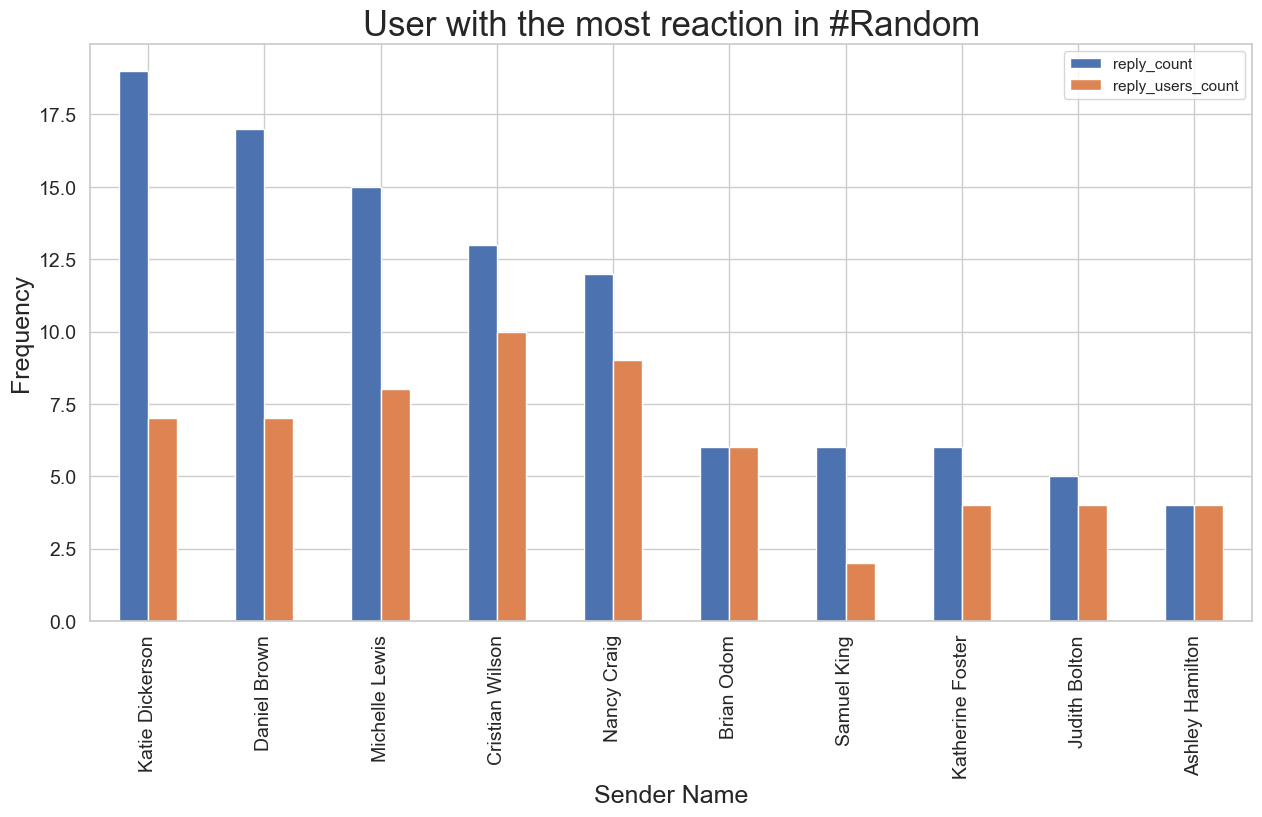

In [20]:
# Which users got the most reactions?
draw_user_reaction(pfill, channel='Random')

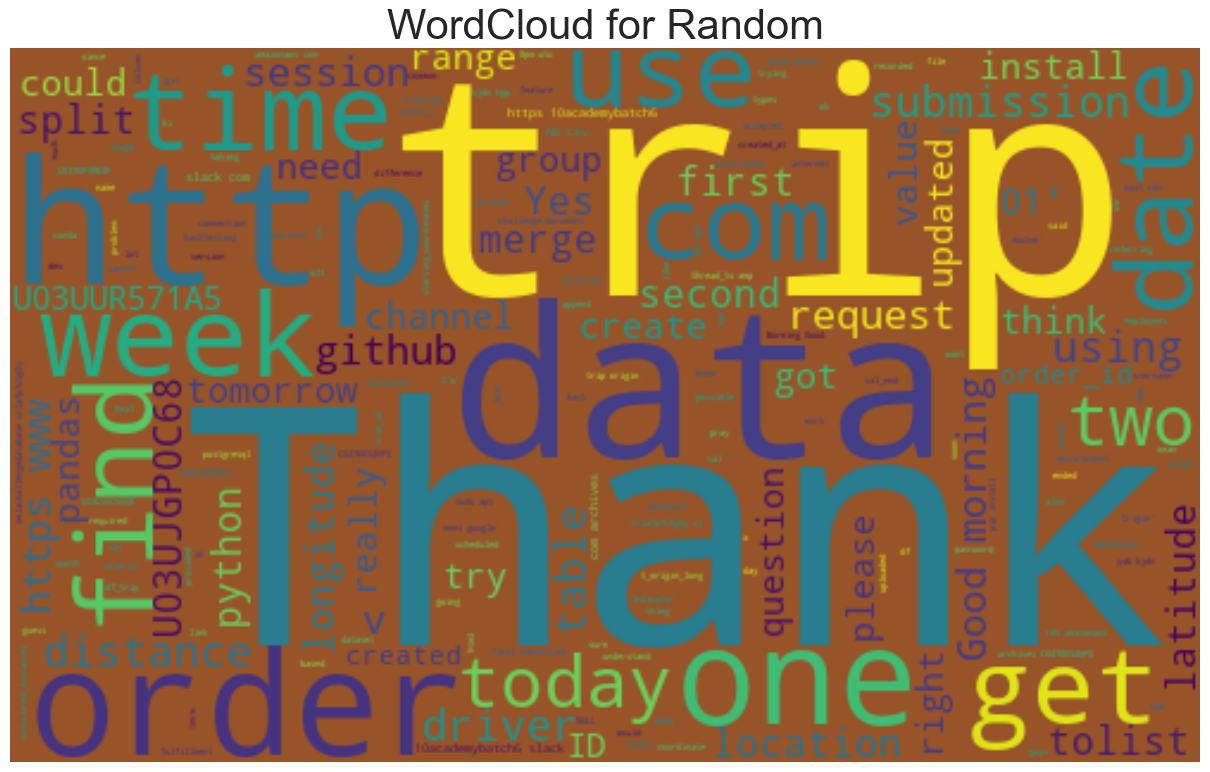

In [21]:
# Model topics mentioned in the channel
draw_wordcloud(pfill['msg_content'], week='Random')

In [ ]:
# What are the topics that got the most reactions?


# Parse Slack reactions for the 'allweeks89' channel
reaction_data = parse_slack_reaction(r'C:/Users/moyka/OneDrive/Documents/GitHub/allweeks89/', 'allweeks89')

# Get the topics with the most reactions
top_reacted_topics = reaction_data.groupby('message')['reaction_count'].sum().sort_values(ascending=False)

# Display the top topics with the most reactions
print(top_reacted_topics.head(10))

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?